In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from bids import BIDSLayout, BIDSLayoutIndexer


def mean_global_fc(matrix, target):

    # Step 1: Calculate the mean and std of each column and the target
    matrix_means = matrix.mean(axis=0)
    matrix_stds = matrix.std(axis=0)
    target_mean = target.mean()
    target_std = target.std()

    # Step 2: Center and normalize the matrix and target
    matrix_centered = (matrix - matrix_means) / matrix_stds
    target_centered = (target - target_mean) / target_std

    # Step 3: Compute the dot product to get correlations for each column
    correlations = np.dot(target_centered, matrix_centered) / (len(target) - 1)

    # Step 4: Calculate the mean correlation
    return np.nanmean(correlations)


load_results = True
radius = 10

if load_results:
    # load the results
    results = pd.read_csv("neuroimaging_summary_results.csv")
    bids_path = "/home/lukeh/hpcworking/lukeH/projects/QNC_outcomes/data/bids/"
    coord_df = pd.read_csv(bids_path+'phenotype/coordinates.tsv',
                           delimiter="\t")
else:
    
    motion_threshold = 0.5

    # get subjects from bids
    indexer = BIDSLayoutIndexer(validate=False, index_metadata=False)
    layout = BIDSLayout(bids_path, indexer=indexer)
    subject_ids = layout.get_subjects()
    subject_ids.remove("159")  # no clinical data (yet)

    for sid in subject_ids:
        files = layout.get(subject=sid, extension=".tsv",
                           return_type="filenames")
        df = pd.read_csv(files[0], delimiter="\t")
        df2 = pd.read_csv(files[1], delimiter="\t")
        motion = np.hstack(
            (df.framewise_displacement.values[1::], df.framewise_displacement.values[1::]))
        motion_avg = np.mean(motion)

        if motion_avg > motion_threshold:
            print("removing", sid)
            subject_ids.remove(sid)

    bids_path = "/home/lukeh/hpcworking/lukeH/projects/QNC_outcomes/data/bids/"
    coord_df = pd.read_csv(bids_path+'phenotype/coordinates.tsv',
                           delimiter="\t")

    path_to_data = "/home/lukeh/hpcworking/lukeH/projects/QNC_outcomes/data/derivatives/fmriprep_24.0.1_denoised_smoothed_ts/"

    # index = 
    # - 0 = HCP SGC
    # - 1 = regular SGC timeseries
    # - 2 = V1
    # - 3 = non adjusted DLPFC individual
    # - 4 = connie adjusted
    # - 5 = connie and surface adjusted

    labels = ["right SGC-HCP", 
              "right SGC", 
              "left V1", 
              "left DLPFC", 
              "left DLPFC adj", 
              "left DLPFC adj surf"]
    sgc_index = 1
    dlpfc_index = 4
    v1_index = 2
    result_list = []
    for subj in tqdm(subject_ids):

        for ses in ["pre", "post"]:
            fname = f"{path_to_data}sub-{subj}/ses-{ses}/sub-{subj}_ses-{ses}_denoise-Ciric36p_filter-butterworth_0.01_0.10_smooth-4_radius-{radius}_.csv"
            data = np.loadtxt(fname, delimiter=",")

            fc = np.corrcoef(data.T)

            # HCP-SGC to individualised DLPFC
            df = pd.DataFrame()
            df['participant_id'] = ["sub-"+subj]
            df['session'] = ses
            df['edge'] = labels[sgc_index]+"-"+labels[dlpfc_index]
            df['fc_value'] = fc[sgc_index, dlpfc_index]
            df['group'] = coord_df.loc[coord_df.participant_id ==
                                       "sub-"+subj, "tier"].values[0]
            result_list.append(df)

            # V1 to individualised DLPFC
            df = pd.DataFrame()
            df['participant_id'] = ["sub-"+subj]
            df['session'] = ses
            df['edge'] = labels[v1_index]+"-"+labels[dlpfc_index]
            df['fc_value'] = fc[v1_index, dlpfc_index]
            df['group'] = coord_df.loc[coord_df.participant_id ==
                                       "sub-"+subj, "tier"].values[0]
            result_list.append(df)

            # A.Z. global connectivity
            fname = f"{path_to_data}sub-{subj}/ses-{ses}/sub-{subj}_ses-{ses}_denoise-Ciric36p_filter-butterworth_0.01_0.10_smooth-4_bold_global.csv"
            global_ts = np.loadtxt(fname, delimiter=",")
            global_r = mean_global_fc(global_ts, data[:, dlpfc_index])

            df = pd.DataFrame()
            df['participant_id'] = ["sub-"+subj]
            df['session'] = ses
            df['edge'] = "globalfc"+"-"+labels[dlpfc_index]
            df['fc_value'] = global_r
            df['group'] = coord_df.loc[coord_df.participant_id == "sub-"+subj, "tier"].values[0]
            result_list.append(df)
    results = pd.concat(result_list)
    results.to_csv("neuroimaging_summary_results.csv", sep=",", index=False)

results.head()

,participant_id,session,edge,fc_value,group
0,sub-092,pre,right SGC-left DLPFC adj,-0.406655,2.0
1,sub-092,pre,left V1-left DLPFC adj,-0.064898,2.0
2,sub-092,pre,globalfc-left DLPFC adj,0.013203,2.0
3,sub-092,post,right SGC-left DLPFC adj,-0.266185,2.0
4,sub-092,post,left V1-left DLPFC adj,0.030046,2.0


r= 0.078 p= 0.70029
r= 0.098 p= 0.62791


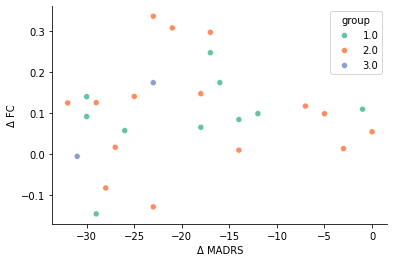

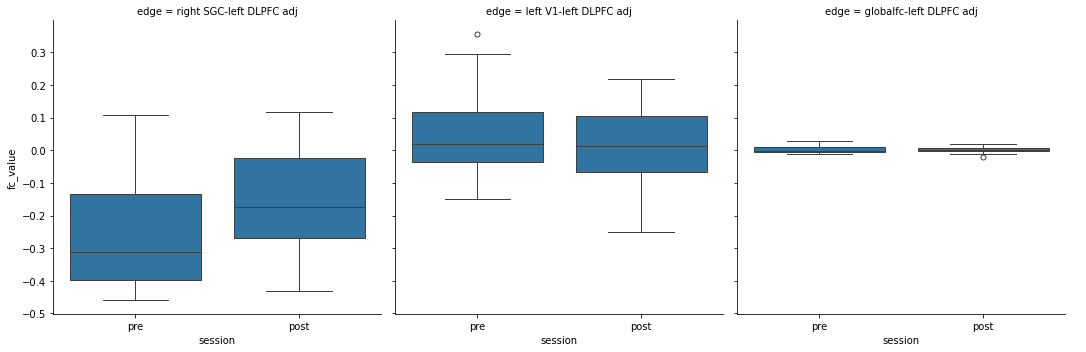

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

plot_df = []
for subj in results.participant_id.unique():
    for edge in ["right SGC-left DLPFC adj", "left V1-left DLPFC adj", "globalfc-left DLPFC adj"]:
        score_change = coord_df.loc[coord_df.participant_id == subj, "change_in_MADRS"].values[0]
        fc_change = (results.loc[(results.participant_id == subj) 
                                & (results.edge == edge)
                                & (results.session == "post"), "fc_value"].values[0]
                    - results.loc[(results.participant_id == subj)
                                & (results.edge == edge)
                                & (results.session == "pre"), "fc_value"].values[0])

        df = pd.DataFrame()
        df['subj'] = [subj]
        df['Δ MADRS'] = score_change
        df['Δ FC'] = fc_change
        df["edge"] = edge
        df['group'] = coord_df.loc[coord_df.participant_id == subj, "tier"].values[0]
        plot_df.append(df)
plot_df = pd.concat(plot_df)


df = plot_df[plot_df.edge == "right SGC-left DLPFC adj"]
r, p = spearmanr(df['Δ MADRS'].values ,df['Δ FC'].values)
print("r=",r.round(3), "p=", p.round(5))
r, p = pearsonr(df['Δ MADRS'].values ,df['Δ FC'].values)
print("r=",r.round(3), "p=", p.round(5))

sns.scatterplot(data=df, x="Δ MADRS", y="Δ FC", hue="group", palette="Set2")
sns.despine()

sns.catplot(data=results, x="session", y="fc_value", col="edge", kind="box")
sns.despine()

In [13]:
results.edge.unique()

array(['right SGC-left DLPFC adj', 'left V1-left DLPFC adj',
       'globalfc-left DLPFC adj'], dtype=object)

In [15]:
import pingouin as pg


a = results.loc[(results.edge == "right SGC-left DLPFC adj")
                             & (results.session == "pre"), "fc_value"].values
b = results.loc[(results.edge == "right SGC-left DLPFC adj")
                             & (results.session == "post"), "fc_value"].values
print("mean_diff=",round(np.mean(a-b), 3))
print(pg.ttest(a, b, paired=True))

a = results.loc[(results.edge == "left V1-left DLPFC adj")
                             & (results.session == "pre"), "fc_value"].values
b = results.loc[(results.edge == "left V1-left DLPFC adj")
                             & (results.session == "post"), "fc_value"].values
print("mean_diff=",round(np.mean(a-b), 3))
print(pg.ttest(a, b, paired=True))

a = results.loc[(results.edge == "globalfc-left DLPFC adj")
                             & (results.session == "pre"), "fc_value"].values
b = results.loc[(results.edge == "globalfc-left DLPFC adj")
                             & (results.session == "post"), "fc_value"].values
print("mean_diff=",round(np.mean(a-b), 3))
print(pg.ttest(a, b, paired=True))

mean_diff= -0.099
              T  dof alternative     p-val           CI95%   cohen-d     BF10  \
T-test -4.33742   26   two-sided  0.000193  [-0.15, -0.05]  0.627706  146.762   

           power  
T-test  0.880817  
mean_diff= 0.031
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.023224   26   two-sided  0.315629  [-0.03, 0.09]  0.258076  0.327   

           power  
T-test  0.252566  
mean_diff= 0.001
               T  dof alternative     p-val        CI95%  cohen-d   BF10  \
T-test  0.328766   26   two-sided  0.744966  [-0.0, 0.0]   0.0583  0.214   

           power  
T-test  0.059817  


# Publication figures

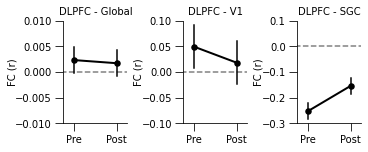

In [34]:
import matplotlib.pyplot as plt


def cousineau_morey_ci(data):
    # Data shape should be (subjects x conditions)
    # Number of subjects
    n_subjects = data.shape[0]

    # Normalize the data by subtracting the subject mean and adding the grand mean
    subject_means = np.mean(data, axis=1)
    grand_mean = np.mean(data)
    normalized_data = (data - subject_means[:, np.newaxis]) + grand_mean

    # CI = Mean +/- t(1-alpha/2, n-1) * SD / sqrt(n) * sqrt(c / (c-1))
    critical_value = 1.96
    m = np.mean(normalized_data, axis=0)
    sem = np.std(normalized_data, axis=0) / np.sqrt(n_subjects)
    correction = np.sqrt(data.shape[1] / (data.shape[1]-1))

    # Calculate the confidence intervals
    ci_lower = m - (critical_value * sem * correction)
    ci_upper = m + (critical_value * sem * correction)

    return ci_lower, ci_upper


plt.rcParams['svg.fonttype'] = 'none'

fig, axs = plt.subplot_mosaic("""
                              ABC
                              """,
                              figsize=(5.0, 2.0),
                              constrained_layout=True)

tier_pal = [sns.color_palette("colorblind")[1],
            sns.color_palette("colorblind")[3],
            np.array((0.4, 0.4, 0.4))]

ylims = np.array([[-0.01, 0.01],
                  [-0.1, 0.1],
                  [-0.3, 0.1]])
titles = ["DLPFC - Global", "DLPFC - V1", "DLPFC - SGC"]
for i, (ax, edge) in enumerate(zip(["A", "B", "C"],
                                   ["globalfc-left DLPFC adj",
                                    "left V1-left DLPFC adj",
                                    "right SGC-left DLPFC adj"])):
    data = results[results.edge == edge]
    sns.pointplot(data=data,
                  x="session",
                  y="fc_value",
                  ax=axs[ax],
                  color="k",
                  markersize=5,
                  lw=2,
                  errorbar=None,
                  zorder=10)

    # plot within-subject CIs
    ci_data = np.vstack((data.loc[data.session == "pre", "fc_value"].values,
                        data.loc[data.session == "post", "fc_value"].values)).T

    cis_upper, cis_lower = cousineau_morey_ci(ci_data)
    axs[ax].plot([0, 0], [cis_upper[0], cis_lower[0]], zorder=5, color="k")
    axs[ax].plot([1, 1], [cis_upper[1], cis_lower[1]], zorder=5, color="k")

    axs[ax].plot([-0.5, 1.5], [0, 0], color="grey", linestyle="--")

    # plot formatting
    axs[ax].tick_params(axis='both', which='major', size=8)
    axs[ax].set_ylim([ylims[i, 0], ylims[i, 1]])
    axs[ax].set_ylabel("FC (r)", labelpad=-2, size=10)
    axs[ax].set_xticks([0, 1], labels=["Pre", "Post"])
    axs[ax].set_xlabel("")
    axs[ax].set_xlim([-0.25, 1.25])
    # ax.set_xticks(np.linspace(0, 1, 3))
    # ax.set_xticklabels(np.linspace(0, 1, 3))
    axs[ax].set_title(titles[i], loc='center', fontsize=10)
    sns.despine(ax=axs[ax])


plt.savefig('../figures/Fig2_imaging_outcomes.svg')
plt.savefig('../figures/Fig2_imaging_outcomes.jpg')
plt.show()


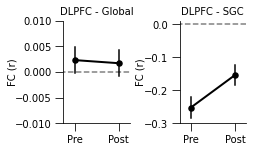

In [36]:
import matplotlib.pyplot as plt


def cousineau_morey_ci(data):
    # Data shape should be (subjects x conditions)
    # Number of subjects
    n_subjects = data.shape[0]

    # Normalize the data by subtracting the subject mean and adding the grand mean
    subject_means = np.mean(data, axis=1)
    grand_mean = np.mean(data)
    normalized_data = (data - subject_means[:, np.newaxis]) + grand_mean

    # CI = Mean +/- t(1-alpha/2, n-1) * SD / sqrt(n) * sqrt(c / (c-1))
    critical_value = 1.96
    m = np.mean(normalized_data, axis=0)
    sem = np.std(normalized_data, axis=0) / np.sqrt(n_subjects)
    correction = np.sqrt(data.shape[1] / (data.shape[1]-1))

    # Calculate the confidence intervals
    ci_lower = m - (critical_value * sem * correction)
    ci_upper = m + (critical_value * sem * correction)

    return ci_lower, ci_upper


plt.rcParams['svg.fonttype'] = 'none'

fig, axs = plt.subplot_mosaic("""
                              AB
                              """,
                              figsize=(3.4, 2.0),
                              constrained_layout=True)

tier_pal = [sns.color_palette("colorblind")[1],
            sns.color_palette("colorblind")[3],
            np.array((0.4, 0.4, 0.4))]

ylims = np.array([[-0.01, 0.01],
                  [-0.3, 0.01]])
titles = ["DLPFC - Global", "DLPFC - SGC"]
for i, (ax, edge) in enumerate(zip(["A", "B", "C"],
                                   ["globalfc-left DLPFC adj",
                                    "right SGC-left DLPFC adj"])):
    data = results[results.edge == edge]
    sns.pointplot(data=data,
                  x="session",
                  y="fc_value",
                  ax=axs[ax],
                  color="k",
                  markersize=5,
                  lw=2,
                  errorbar=None,
                  zorder=10)

    # plot within-subject CIs
    ci_data = np.vstack((data.loc[data.session == "pre", "fc_value"].values,
                        data.loc[data.session == "post", "fc_value"].values)).T

    cis_upper, cis_lower = cousineau_morey_ci(ci_data)
    axs[ax].plot([0, 0], [cis_upper[0], cis_lower[0]], zorder=5, color="k")
    axs[ax].plot([1, 1], [cis_upper[1], cis_lower[1]], zorder=5, color="k")

    axs[ax].plot([-0.5, 1.5], [0, 0], color="grey", linestyle="--")

    # plot formatting
    axs[ax].tick_params(axis='both', which='major', size=8)
    axs[ax].set_ylim([ylims[i, 0], ylims[i, 1]])
    axs[ax].set_ylabel("FC (r)", labelpad=-2, size=10)
    axs[ax].set_xticks([0, 1], labels=["Pre", "Post"])
    axs[ax].set_xlabel("")
    axs[ax].set_xlim([-0.25, 1.25])
    # ax.set_xticks(np.linspace(0, 1, 3))
    # ax.set_xticklabels(np.linspace(0, 1, 3))
    axs[ax].set_title(titles[i], loc='center', fontsize=10)
    sns.despine(ax=axs[ax])


plt.savefig('../figures/Fig2_imaging_outcomes.svg')
plt.savefig('../figures/Fig2_imaging_outcomes.jpg')
plt.show()


# test

In [ ]:
import pandas as pd

# Define the data as a dictionary
data = {
    'A1': [241, 209, 211, 167, 190, 207, 163, 172, 171, 187, 181, 164, 139, 153, 165, 158, 199, 180],
    'A2': [178, 236, 170, 155, 166, 189, 157, 149, 174, 196, 204, 171, 139, 138, 169, 174, 207, 188],
    'B1': [253, 306, 462, 204, 225, 276, 231, 284, 199, 196, 192, 250, 181, 175, 209, 204, 294, 215],
    'B2': [215, 344, 521, 204, 271, 281, 266, 251, 263, 207, 244, 268, 191, 198, 245, 229, 292, 262],
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Print the DataFrame
data = df.values

In [ ]:
import numpy as np
import pandas as pd

def cousineau_morey_ci(data):
    # See: https://motorbehaviour.wordpress.com/2014/10/31/confidence-intervals-in-within-participant-design-a-tutorial-on-the-cousineau-morey-method/
    # Data shape should be (subjects x conditions)
    # Number of subjects
    n_subjects = data.shape[0]

    # Normalize the data by subtracting the subject mean and adding the grand mean
    subject_means = np.mean(data, axis=1)
    grand_mean = np.mean(data)
    normalized_data = (data - subject_means[:, np.newaxis]) + grand_mean

    # CI = Mean +/- t(1-alpha/2, n-1) * SD / sqrt(n) * sqrt(c / (c-1))
    critical_value = 1.96
    m = np.mean(normalized_data, axis=0)
    sem = np.std(normalized_data, axis=0) / np.sqrt(n_subjects)
    correction = np.sqrt(data.shape[1] / (data.shape[1]-1))

    # Calculate the confidence intervals
    ci_lower = m - (critical_value * sem * correction)
    ci_upper = m + (critical_value * sem * correction)

    return ci_lower, ci_upper


# data.shape
# cousineau_morey_ci(data)

In [ ]:
4/3

In [ ]:
np.mean(normalized_data, axis=0)

In [ ]:
np.std(normalized_data, axis=0)

In [ ]:
print(ci)

In [ ]:
data.head(2)

In [ ]:
import seaborn as sns
sns.catplot(data=results, x="session", y="fc_value", col="edge", kind="point")
sns.despine()
plt.show()
import seaborn as sns
sns.catplot(data=results, x="session", y="fc_value", col="edge", kind="point", units="participant_id")
sns.despine()


In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of subjects
num_subjects = 30

# Number of measurements per subject per session
num_measurements = 10

# Generate subject IDs
subject_ids = np.arange(1, num_subjects + 1)

# Generate large between-subjects variability
between_subjects_variability = np.random.normal(loc=100, scale=50, size=num_subjects)

# Generate small within-subject variability for pre and post sessions
within_subjects_variability_pre = np.random.normal(loc=0, scale=5, size=(num_subjects, num_measurements))
within_subjects_variability_post = np.random.normal(loc=0, scale=5, size=(num_subjects, num_measurements))

# Create the dataset
data = []
for i in range(num_subjects):
    subject_data_pre = between_subjects_variability[i] + within_subjects_variability_pre[i]
    subject_data_post = between_subjects_variability[i] + within_subjects_variability_post[i]
    for measurement in subject_data_pre:
        data.append({'SubjectID': subject_ids[i], 'Session': 'pre', 'Measurement': measurement})
    for measurement in subject_data_post:
        data.append({'SubjectID': subject_ids[i], 'Session': 'post', 'Measurement': measurement})

df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(df.head())


In [ ]:
sns.pointplot(data=df, x="Session", y="Measurement", units="SubjectID")